# Churn Telecom

Esse projeto tem como objetivo de criar um modelo que consiga apontar com assertividade quais clientes tem probabilidade de cancelar o plano com a operadora. Além disso, a missão é compreender o que mais colabora para que o cliente cancele.

## Bibliotecas que serão utilizadas nesse projeto

In [1]:
from pyspark.sql.types import *
from pyspark.sql import functions as F
from pyspark.sql import SparkSession
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import Imputer
from pyspark.ml import Pipeline
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator
from pyspark.ml.tuning import ParamGridBuilder
from sklearn.metrics import confusion_matrix

import pandas as pd

# Visualização de dados
import matplotlib.pyplot as plt
import seaborn as sns

## Sessão do Spark

In [2]:
sparkSession = SparkSession.builder.appName("churn-telco").getOrCreate()

## Leitura da base

In [3]:
# Passando esquema
schema = StructType([
        StructField("ID", IntegerType(), True),
        StructField("customerID", StringType(), True),
        StructField("gender", StringType(), True),
        StructField("SeniorCitizen", StringType(), True),
        StructField("Partner", StringType(), True),
        StructField("Dependents", StringType(), True),
        StructField("tenure", IntegerType(), True),
        StructField("PhoneService", StringType(), True),
        StructField("MultipleLines", StringType(), True),
        StructField("InternetService", StringType(), True),
        StructField("OnlineSecurity", StringType(), True),
        StructField("OnlineBackup ", StringType(), True),
        StructField("DeviceProtection", StringType(), True),
        StructField("TechSupport", StringType(), True),
        StructField("StreamingTV", StringType(), True),
        StructField("StreamingMovies ", StringType(), True),
        StructField("Contract", StringType(), True),
        StructField("PaperlessBilling", StringType(), True),
        StructField("PaymentMethod", StringType(), True),
        StructField("MonthlyCharges", DoubleType(), True),
        StructField("TotalCharges", DoubleType(), True),
        StructField("Churn", StringType(), True),
    ])

In [4]:
df = sparkSession.read.csv('../dataset/*.csv', header = True, schema = schema)

In [5]:
df.select([df.columns[i] for i in range(len(df.columns)) if i < 10]).show(truncate=False)

+----+----------+------+-------------+-------+----------+------+------------+----------------+---------------+
|ID  |customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines   |InternetService|
+----+----------+------+-------------+-------+----------+------+------------+----------------+---------------+
|1869|7010-BRBUU|Male  |0            |Yes    |Yes       |72    |Yes         |Yes             |No             |
|4528|9688-YGXVR|Female|0            |No     |No        |44    |Yes         |No              |Fiber optic    |
|6344|9286-DOJGF|Female|1            |Yes    |No        |38    |Yes         |Yes             |Fiber optic    |
|6739|6994-KERXL|Male  |0            |No     |No        |4     |Yes         |No              |DSL            |
|432 |2181-UAESM|Male  |0            |No     |No        |2     |Yes         |No              |DSL            |
|2215|4312-GVYNH|Female|0            |Yes    |No        |70    |No          |No phone service|DSL            |
|

##  1- Análise descritiva/Exploratória dos dados

### Nesta etapa aprofundaremos um pouco nos dados que temos para entender melhor sobre o negócio que temos em mãos. Ressalto que essa é a parte mais importante de qualquer projeto de data science. Caso você não tenha em mãos dados que te contem sobre como funciona o negócio, sinto lhe dizer que o projeto não dará certo.

In [6]:
# Quantidade de clientes existem na base
df.select('customerID').distinct().count()

5986

In [7]:
# Summary
df.summary().toPandas()

summary                  ID  customerID  gender        SeniorCitizen  \
0   count                5986        5986    5986                 5986   
1    mean  3533.5613097226865        None    None  0.16137654527230202   
2  stddev   2035.705665830562        None    None   0.3679086410122609   
3     min                   0  0002-ORFBO  Female                    0   
4     25%                1777        None    None                  0.0   
5     50%                3546        None    None                  0.0   
6     75%                5292        None    None                  0.0   
7     max                7042  9993-LHIEB    Male                    1   

  Partner Dependents              tenure PhoneService MultipleLines  ...  \
0    5986       5986                5986         5986          5986  ...   
1    None       None   32.46876044102907         None          None  ...   
2    None       None  24.516390637526726         None          None  ...   
3      No         No                   0           No            No  ...   
4    None       None                   9         None          None  ...   
5    None       None                  29         None          None  ...   
6    None       None                  56         None          None  ...   
7     Yes        Yes                  72          Yes           Yes  ...   

  DeviceProtection TechSupport StreamingTV StreamingMovies         Contract  \
0             5986        5986        5986             5986            5986   
1             None        None        None             None            None   
2             None        None        None             None            None   
3               No          No          No               No  Month-to-month   
4             None        None        None             None            None   
5             None        None        None             None            None   
6             None        None        None             None            None   
7              Yes         Yes         Yes              Yes        Two year   

  PaperlessBilling              PaymentMethod      MonthlyCharges  \
0             5986                       5986                5986   
1             None                       None    64.8022134981624   
2             None                       None  30.114701633888114   
3               No  Bank transfer (automatic)               18.25   
4             None                       None               35.65   
5             None                       None                70.4   
6             None                       None                89.9   
7              Yes               Mailed check              118.75   

         TotalCharges Churn  
0                5976  5986  
1  2298.0606174698796  None  
2  2274.1271654402035  None  
3                18.8    No  
4               404.2  None  
5              1411.9  None  
6             3846.75  None  
7              8684.8   Yes  

[8 rows x 23 columns]


- (1) Proporção de clientes para quem cancela e quem fica

In [8]:
# Proporção de clientes para quem cancela e quem fica
df.groupBy('Churn').count().show()

+-----+-----+
|Churn|count|
+-----+-----+
|   No| 4399|
|  Yes| 1587|
+-----+-----+



### Uma informação importante é que a proporção de clientes que ficam é maior do que os que cancelam. Isso é um problema muito comum quando se trata do assunto (Churn). Muitas vezes isso pode ocasionar no famoso desbalanceamento de classes. Porém, mais adiante trataremos disso.

- (2) Tempo de fidelidade dos clientes

<AxesSubplot:>

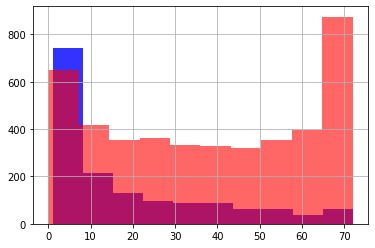

In [9]:
# Analisando o tempo de quem saiu e permaneceu na empresa
tempo = df.select('Churn','tenure').toPandas()
tempo[tempo.Churn == 'Yes']['tenure'].hist(alpha = 0.8, color = 'blue')
tempo[tempo.Churn == 'No']['tenure'].hist(alpha = 0.6, color = 'red')


### Ao analisar o tempo de fidelidade de cada cliente ao produto, percebemos que tiveram clientes que cancelaram depois de um longo tempo, mas que a maioria cancelou entre os 10-20 primeiros meses. Será que existe algum fator que esteja ocasionando nessa saída recente? 

- (3) Produtos dos clientes que ficaram/saíram

<AxesSubplot:xlabel='InternetService', ylabel='count'>

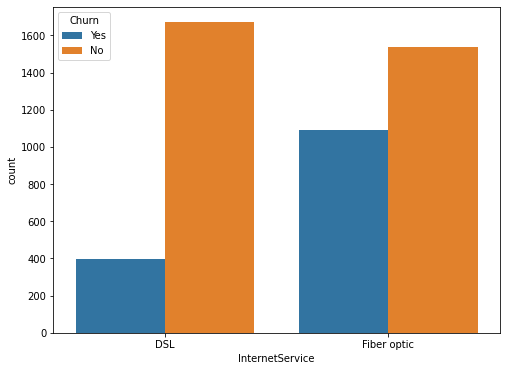

In [10]:
# Tipo de internet para clientes que saíram e permaneceram (revisar essa parte)
plt.figure(figsize=(8,6))

df_internet_service = df.filter(df.InternetService != 'No').groupBy('Churn', 'InternetService').count().orderBy(df.Churn.desc()).toPandas()

sns.barplot(
data = df_internet_service , x = 'InternetService', y= 'count', hue = 'Churn')

### De acordo com a análise, tanto os clientes que saíram e ficaram tiveram/tem os mesmos produtos. Porém, um ponto de observação é que para aqueles que cancelaram, a Fibra optica é a mais presente. 

- (4) Total de recargas para clientes que ficaram ou saíram

<AxesSubplot:>

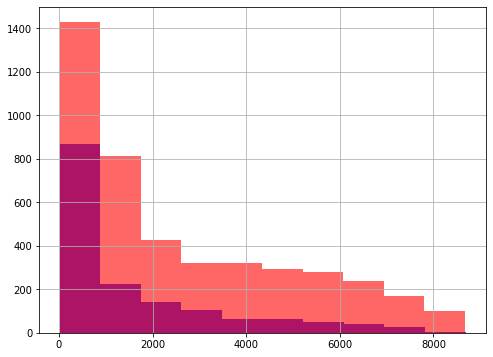

In [11]:
# Total de recargas para o cliente que permanceu e para quem cancelou
plt.figure(figsize=(8,6))
charge = df.select('Churn','TotalCharges').toPandas()
charge[charge.Churn == 'Yes']['TotalCharges'].hist(alpha = 0.8, color = 'blue')
charge[charge.Churn == 'No']['TotalCharges'].hist(alpha = 0.6, color = 'red')

### Referente a total de cargas realizadas, aqui vemos que quem cancela geralmente não costuma fazer muita recarga... 

- (5) Contrato de clientes que ficaram/saíram

In [12]:
# Tipo de contrato para clientes que saíram e permaneceram (revisar essa parte)
plt.figure(figsize=(8,6))
df_contrato = df.groupBy('Churn', 'Contract').count().orderBy(df.Churn.desc()).toPandas()

sns.barplot(data = df_contrato, x='Contract', y='count', hue='Churn')



<AxesSubplot:xlabel='Contract', ylabel='count'>

### A maioria dos clientes que cancelam tem um contrato de Mês a mês. 

- (6) Serviço de celular de clientes que ficaram/saíram

<AxesSubplot:xlabel='PhoneService', ylabel='count'>

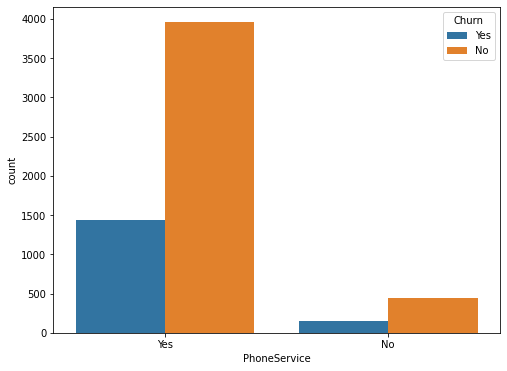

In [13]:
# Serviço de celular
plt.figure(figsize=(8,6))
df_cell_phone = df.groupBy('Churn', 'PhoneService').count().orderBy(df.Churn.desc()).toPandas()
sns.barplot(data = df_cell_phone, x = 'PhoneService', y = 'count', hue = 'Churn')

### Pessoas que contém serviço de celular costumam mudar de produto mais facilmente

- (7) Multiplas linhas de clientes que ficaram/saíram

In [14]:
# Multiplas linhas de telefone
plt.figure(figsize=(8,6))

df_multiplas_linhas = df.groupBy('Churn', 'MultipleLines').count().orderBy(df.Churn.desc()).toPandas()
sns.barplot(data = df_multiplas_linhas, x='MultipleLines', y = 'count', hue = 'Churn')

<AxesSubplot:xlabel='MultipleLines', ylabel='count'>

### Aqui podemos ver que o fato de ter multiplas linhas não é algo determinante para a desistência do cliente do produto em si

- (8) Aposentados de clientes que ficaram/saíram

<AxesSubplot:xlabel='SeniorCitizen', ylabel='count'>

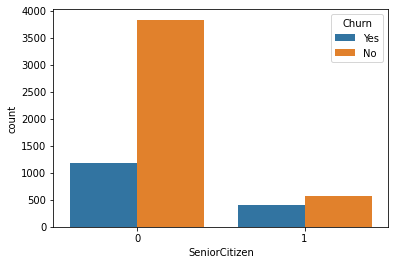

In [15]:
# Aposentados
df_aposentados = df.groupBy('Churn', 'SeniorCitizen').count().orderBy(df.Churn.desc()).toPandas()
sns.barplot(data = df_aposentados, x='SeniorCitizen', y = 'count', hue = 'Churn')

### A proporção de aposentados que cancelaram ou continuaram o plano parece ser equilibrada, sendo bem diferente da proporção daqueles que não são aposentados

- (9) Aposentados/Não aposentados que contém ou não parceiros (considerando a variável Churn)

Text(0.5, 1.0, 'Partner Status')

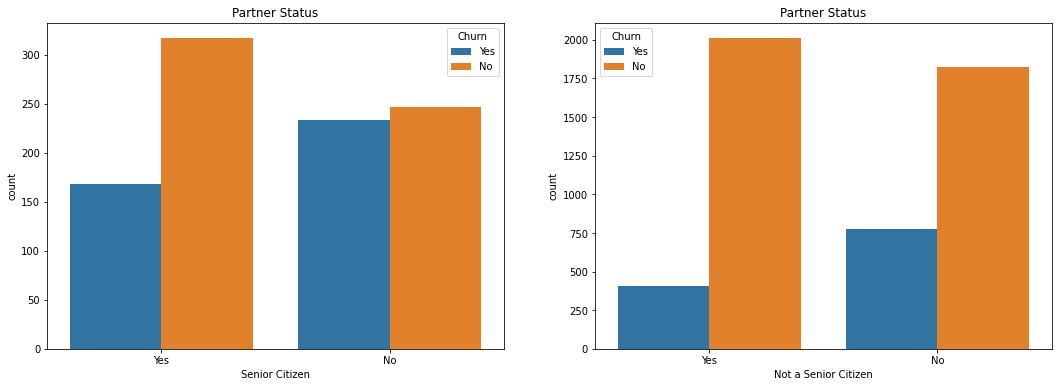

In [16]:
# Drill Down para melhor averiguar aposentados
df_aposentado = df.filter(df.SeniorCitizen == 1).groupBy('Churn', 'Partner').count().orderBy(df.Churn.desc()).toPandas()
df_nao_aposentado = df.filter(df.SeniorCitizen == 0).groupBy('Churn', 'Partner').count().orderBy(df.Churn.desc()).toPandas()
plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
sns.barplot(data = df_aposentado, x = 'Partner', y = 'count', hue = 'Churn')
plt.xlabel('Senior Citizen')
plt.title('Partner Status')
plt.subplot(1,2,2)
sns.barplot(data = df_nao_aposentado, x = 'Partner', y = 'count', hue = 'Churn')
plt.xlabel('Not a Senior Citizen')
plt.title('Partner Status')

### A taxa de cancelamento daqueles que são aposentados e não tem parceiros é maior do que os que tem parceiros
### Os não aposentados que contém parceiros ou não, contém uma taxa bem menor de cancelamento

- (10) Aposentados com dependentes ou sem dependentes (em relação a variável Churn)

Text(0.5, 1.0, 'Dependents Status')

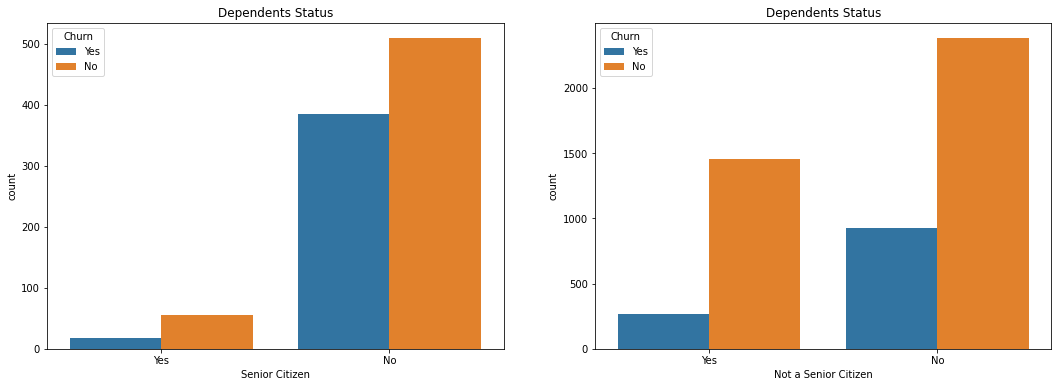

In [17]:
# Drill Down para melhor averiguar aposentados
df_aposentado = df.filter(df.SeniorCitizen == 1).groupBy('Churn', 'Dependents').count().orderBy(df.Churn.desc()).toPandas()
df_nao_aposentado = df.filter(df.SeniorCitizen == 0).groupBy('Churn', 'Dependents').count().orderBy(df.Churn.desc()).toPandas()
plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
sns.barplot(data = df_aposentado, x = 'Dependents', y = 'count', hue = 'Churn')
plt.xlabel('Senior Citizen')
plt.title('Dependents Status')
plt.subplot(1,2,2)
sns.barplot(data = df_nao_aposentado, x = 'Dependents', y = 'count', hue = 'Churn')
plt.xlabel('Not a Senior Citizen')
plt.title('Dependents Status')

### A taxa de cancelamento para aposentador com dependentes é maior do que não aposentados com dependentes

- (11) Quantidade de meses que um aposentado permanece com o produto/ou não

In [18]:
df_box = df.select('SeniorCitizen', 'Churn', 'tenure').toPandas()
sns.boxplot(y = 'tenure', x = 'SeniorCitizen', data = df_box, hue = 'Churn')

<AxesSubplot:xlabel='SeniorCitizen', ylabel='tenure'>

### Os aposentados que cancelam tem praticamente a mesma proporção de meses dos não aposentados que cancelam

- (12) Recargas entre aposentados/não aposentados (referente a variável churn)


<AxesSubplot:xlabel='SeniorCitizen', ylabel='MonthlyCharges'>

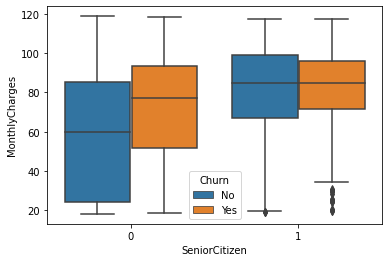

In [19]:
# Analisando dispersão das cargas mensais
df_box_charges = df.select('SeniorCitizen', 'Churn', 'MonthlyCharges').toPandas()
sns.boxplot(y = 'MonthlyCharges', x = 'SeniorCitizen', data = df_box_charges, hue = 'Churn')

### Para aqueles que cancelam e não são aposentados, as recargas mensais são maiores. Já entre os aposentados, não existe uma distinção significativa.

- (13) Total de cargas mensais para aposentados e não aposentados

In [20]:
# Analisando dispersão de total de cargas mensais
df_box_total_charges = df.select('SeniorCitizen', 'Churn', 'TotalCharges').toPandas()
sns.boxplot(y = 'TotalCharges', x = 'SeniorCitizen', data = df_box_total_charges, hue = 'Churn')

<AxesSubplot:xlabel='SeniorCitizen', ylabel='TotalCharges'>

### Clientes com total de cargas altas tendem a permanecer com o produto (aposentados ou não).

## Pré-Processamento

## Nesta etapa vamos fazer alguns tratamentos necessários antes de aplicarmos nossos modelos

- (14) Checando valores nulos

In [21]:
df.select(*(F.sum(F.col(c).isNull().cast("int")).alias(c) for c in df.columns)).show(vertical = True)

-RECORD 0---------------
 ID               | 0   
 customerID       | 0   
 gender           | 0   
 SeniorCitizen    | 0   
 Partner          | 0   
 Dependents       | 0   
 tenure           | 0   
 PhoneService     | 0   
 MultipleLines    | 0   
 InternetService  | 0   
 OnlineSecurity   | 0   
 OnlineBackup     | 0   
 DeviceProtection | 0   
 TechSupport      | 0   
 StreamingTV      | 0   
 StreamingMovies  | 0   
 Contract         | 0   
 PaperlessBilling | 0   
 PaymentMethod    | 0   
 MonthlyCharges   | 0   
 TotalCharges     | 10  
 Churn            | 0   



- (15) Substituindo valores nulos pela média

In [22]:
imputer = Imputer(inputCol="TotalCharges", outputCol="TotalCharges_na").setStrategy("mean")
df = imputer.fit(df).transform(df)

- (16) Avaliando matriz de correção

In [23]:
columns = [i for i in df.columns if df.select(i).dtypes[0][1] != 'string' and i != 'ID' and i != 'TotalCharges']
vetor = "corr_features"
vct_assembler = VectorAssembler(inputCols=columns, outputCol=vetor)
df_vetor = vct_assembler.transform(df.select(columns)).select(vetor)
matrix = Correlation.corr(df_vetor, 'corr_features', method = 'pearson')
result = matrix.collect()[0]["pearson({})".format(vetor)].values
pd.DataFrame(result.reshape(-1, len(columns)), columns=columns, index=columns)


tenure  MonthlyCharges  TotalCharges_na
tenure           1.000000        0.256983         0.826223
MonthlyCharges   0.256983        1.000000         0.655830
TotalCharges_na  0.826223        0.655830         1.000000

### De acordo com a matrix de correlação, podemos excluir a variável TotalCharges para evitar problemas com multicolinearidade

In [24]:
df = df.drop('TotalCharges', 'TotalCharges_na', 'ID', 'customerID')

In [25]:
df.show(1, vertical = True)

-RECORD 0--------------------------------
 gender           | Male                 
 SeniorCitizen    | 0                    
 Partner          | Yes                  
 Dependents       | Yes                  
 tenure           | 72                   
 PhoneService     | Yes                  
 MultipleLines    | Yes                  
 InternetService  | No                   
 OnlineSecurity   | No internet service  
 OnlineBackup     | No internet service  
 DeviceProtection | No internet service  
 TechSupport      | No internet service  
 StreamingTV      | No internet service  
 StreamingMovies  | No internet service  
 Contract         | Two year             
 PaperlessBilling | No                   
 PaymentMethod    | Credit card (auto... 
 MonthlyCharges   | 24.1                 
 Churn            | No                   
only showing top 1 row



- (17) Transformando variáveis categóricas em numéricas

In [26]:
indexers = [StringIndexer(inputCol=i, outputCol=i+"_index").fit(df) for i in df.columns if df.select(i).dtypes[0][1] == 'string']

- (18) Colocando das variáveis em um único vetor

In [27]:
featureIndexer = VectorAssembler(inputCols = [i + "_index" for i in df.columns if i != 'Churn' if i != 'Churn_index' if i != 'tenure' if i != 'MonthlyCharges'] + ['tenure', 'MonthlyCharges'], outputCol="features")

- (19) Separando em treino e teste

In [28]:
(trainingData, testData) = df.randomSplit([0.7, 0.3])


- (20) Chamando modelo GTB

In [29]:
gbt = GBTClassifier(labelCol="Churn_index", featuresCol="features")

- (21) Implementando pipeline

In [30]:
# Criando pipeline
stages = indexers
stages.append(featureIndexer)
stages.append(gbt)
pipeline = Pipeline().setStages(stages)

## Treinamento de modelos

- (22) Treinando o modelo

In [31]:
model = pipeline.fit(trainingData)
model_apply = model.transform(testData)

## Avaliação do modelo

- Apenas para facilitar nossos testes, serão criadas algumas funções para ajudar na criação de pipelines e na avaliação de modelos.

In [32]:
# Avaliando acurácia, precisão, revocação e medida F
def evaluate_model(model, prediction):
    metricas = ['accuracy', 'weightedPrecision', 'weightedRecall', 'weightedFMeasure']
    resultados = dict()

    for eval in metricas:
        evaluator = MulticlassClassificationEvaluator(
            labelCol="Churn_index", predictionCol=prediction, metricName=eval
            )
        resultados[eval] = evaluator.evaluate(model)

    for metric in resultados:
        print(f'{metric}: {resultados[metric]}')
    
    roc(model)
    matrix_confusao(model, prediction)

def roc(model):
    # Avaliando curva ROC
    roc_evaluator = BinaryClassificationEvaluator(labelCol='Churn_index')
    auroc = roc_evaluator.evaluate(model, {roc_evaluator.metricName: "areaUnderROC"})
    auprc = roc_evaluator.evaluate(model, {roc_evaluator.metricName: "areaUnderPR"})
    print("Area abaixo da curva ROC: {:.4f}".format(auroc))
    print("Area abaixo da curva PR: {:.4f}".format(auprc))

# Criando matrix de confusão
def matrix_confusao(df, prediction):
    y_true = df.select("Churn_index").toPandas()
    y_pred = df.select(prediction).toPandas()
    print('\n --------------- MATRIZ DE CONFUSAO --------------- \n')
    print(confusion_matrix(y_true, y_pred))

def criando_pipeline(df, variaveis, variaveis_numericas,  outputcol, model):

    # Chamando método para transformar variáveis categóricas em numéricas
    indexers = [StringIndexer(inputCol=i, outputCol=i+"_index").fit(df) for i in df.columns if df.select(i).dtypes[0][1] == 'string']
    featureIndexer = VectorAssembler(inputCols = [i + "_index" for i in df.columns if i not in variaveis] + variaveis_numericas, outputCol=f'features_{outputcol}')

    if model == 'GBT':
        mdl = GBTClassifier(labelCol="Churn_index", featuresCol=f'features_{outputcol}',predictionCol=f'prediction_{outputcol}')

    elif model == 'Random':
        mdl = RandomForestClassifier(labelCol="Churn_index", featuresCol=f'features_{outputcol}',predictionCol=f'prediction_{outputcol}')
            
    elif model == 'Logistic':
        mdl = LogisticRegression(labelCol="Churn_index", featuresCol=f'features_{outputcol}',predictionCol=f'prediction_{outputcol}')

    # Criando pipeline
    stages = indexers
    stages.append(featureIndexer)
    stages.append(mdl)
    return Pipeline().setStages(stages), mdl
   


- (23) Avaliando modelo

In [33]:
evaluate_model(model_apply, 'prediction')

accuracy: 0.7897142857142857
weightedPrecision: 0.7784733409946223
weightedRecall: 0.7897142857142857
weightedFMeasure: 0.7806361618331542
Area abaixo da curva ROC: 0.8380
Area abaixo da curva PR: 0.6237

 --------------- MATRIZ DE CONFUSAO --------------- 

[[1146  131]
 [ 237  236]]


- (24) Verificando grau de importância de cada variável de acordo com o modelo GBT

In [34]:
colunas = model_apply.select([i for i in model_apply.columns if '_index' not in i]).columns

In [35]:
importancia = pd.DataFrame([model.stages[-1].featureImportances.indices, model.stages[-1].featureImportances.values]).transpose().rename(columns= {0: "indices", 1: "valores"}).sort_values(by='valores', ascending=True).reset_index(drop=True)

In [36]:
importancia['indices'] = importancia['indices'].astype(int)
importancia['categoria'] = importancia['indices'].apply(lambda x: colunas[x])

/home/joaoflauzino/miniconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17]),
 [Text(0, 0, 'tenure'),
  Text(1, 0, 'gender'),
  Text(2, 0, 'Partner'),
  Text(3, 0, 'SeniorCitizen'),
  Text(4, 0, 'Dependents'),
  Text(5, 0, 'StreamingTV'),
  Text(6, 0, 'OnlineBackup '),
  Text(7, 0, 'TechSupport'),
  Text(8, 0, 'OnlineSecurity'),
  Text(9, 0, 'Contract'),
  Text(10, 0, 'MultipleLines'),
  Text(11, 0, 'PhoneService'),
  Text(12, 0, 'DeviceProtection'),
  Text(13, 0, 'PaperlessBilling'),
  Text(14, 0, 'InternetService'),
  Text(15, 0, 'MonthlyCharges'),
  Text(16, 0, 'StreamingMovies '),
  Text(17, 0, 'PaymentMethod')])

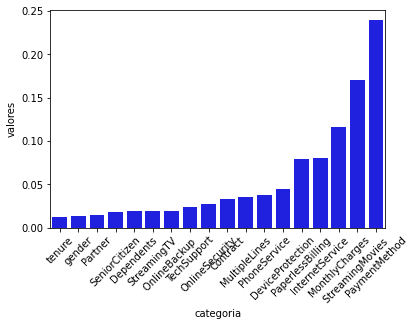

In [37]:
# Consultando a importância das variáveis para o modelo
sns.barplot(importancia['categoria'], importancia['valores'], color='blue')
plt.xticks(rotation=45)

### De acordo com o gráfico acima, algumas variáveis não são tão importantes, portanto, iremos rodaremos o modelo novamente para avaliar mudanças significativas nas métricas do modelo


- (25) Retreinando o modelo

In [38]:
(trainingData, testData) = df.randomSplit([0.7, 0.3])
variaveis_ignoradas_vetor = ['Churn', 'Churn_index', 'tenure', 'MultipleLines_index', 'OnlineBackup_index', 'Dependents_index', 'gender_index', 'MonthlyCharges']
variaveis_numericas = ['MonthlyCharges', 'tenure']
model_gbt = criando_pipeline(df, variaveis_ignoradas_vetor, variaveis_numericas, 'gbt', 'GBT')[0].fit(trainingData).transform(testData)

In [39]:
evaluate_model(model_gbt, 'prediction_gbt')

accuracy: 0.773543821448013
weightedPrecision: 0.7595733466043784
weightedRecall: 0.773543821448013
weightedFMeasure: 0.7625522347410969
Area abaixo da curva ROC: 0.8309
Area abaixo da curva PR: 0.6340

 --------------- MATRIZ DE CONFUSAO --------------- 

[[1195  147]
 [ 269  226]]


### Mesmo retirando algumas variáveis menos importante, não houve melhoras significativas no modelo

## Aplicando RandomForest 

- (26) Treinando o modelo com random forest

In [40]:
variaveis_ignoradas_vetor = ['Churn', 'Churn_index', 'tenure', 'MonthlyCharges']
variaveis_numericas = ['MonthlyCharges', 'tenure']
model_random = criando_pipeline(df, variaveis_ignoradas_vetor, variaveis_numericas, 'random', 'Random')[0].fit(trainingData)
model_apply_random = model_random.transform(testData)

In [41]:
evaluate_model(model_apply_random, 'prediction_random')

accuracy: 0.7822536744692433
weightedPrecision: 0.7670995088474737
weightedRecall: 0.7822536744692434
weightedFMeasure: 0.7582018622614596
Area abaixo da curva ROC: 0.8414
Area abaixo da curva PR: 0.6380

 --------------- MATRIZ DE CONFUSAO --------------- 

[[1256   86]
 [ 314  181]]



### Aplicando random forest também não houve um resultado que bata os modelos anteriores. Outra observação é que em todos os casos a assertividade da classe minoritária ficou inferior a 50%. 

## Aplicando Regressão Logística

- (27) Treinando o modelo com Regressão Logística

In [42]:
variaveis_ignoradas_vetor = ['Churn', 'Churn_index', 'weight', 'tenure', 'MonthlyCharges']
variaveis_numericas = ['MonthlyCharges', 'tenure']
model_random_weigths = criando_pipeline(df, variaveis_ignoradas_vetor, variaveis_numericas, 'random_reg', 'Logistic')[0].fit(trainingData)
model_random_apply_weigths = model_random_weigths.transform(testData)
evaluate_model(model_random_apply_weigths, 'prediction_random_reg')

accuracy: 0.789330430048993
weightedPrecision: 0.7775844570527992
weightedRecall: 0.789330430048993
weightedFMeasure: 0.7796133148411474
Area abaixo da curva ROC: 0.8424
Area abaixo da curva PR: 0.6548

 --------------- MATRIZ DE CONFUSAO --------------- 

[[1207  135]
 [ 252  243]]


### Mesmo aplicando regressão logística os resultados não melhoraram. Outra observação é que em todos os casos a assertividade da classe minoritária ficou inferior a 50%. 

## Utilizando outras técnicas para lidar com  classes desbalanceadas

- (28) A fim de melhorar o modelo, vamos tentar utilizar undersampling. Resumidamente vamos extrair da classe majoritária a proporção da classe minoritária pela majoritária.

In [43]:
churn = df.filter(df.Churn == 'Yes')
no_churn = df.filter(df.Churn == 'No')

sampleRatio = churn.count() / df.count()
noChurn = no_churn.filter(df.Churn == 'No').sample(False, sampleRatio)

In [44]:
df_final = churn.union(noChurn)

In [45]:
(trainingData_under, testData_under) = df_final.randomSplit([0.7, 0.3])

In [46]:
for i in ['GBT', 'Random', 'Logistic']:
    variaveis_ignoradas_vetor = ['Churn', 'Churn_index', 'weight', 'tenure', 'MonthlyCharges']
    variaveis_numericas = ['MonthlyCharges', 'tenure']
    model_random_weigths = criando_pipeline(df_final, variaveis_ignoradas_vetor, variaveis_numericas, i, i)[0].fit(trainingData_under)
    model_random_apply_weigths = model_random_weigths.transform(testData_under)
    print(f'\n {i} \n')
    evaluate_model(model_random_apply_weigths, f'prediction_{i}')


 GBT 

accuracy: 0.7616707616707616
weightedPrecision: 0.7596888212648418
weightedRecall: 0.7616707616707616
weightedFMeasure: 0.7599968393555567
Area abaixo da curva ROC: 0.8232
Area abaixo da curva PR: 0.7567

 --------------- MATRIZ DE CONFUSAO --------------- 

[[402  85]
 [109 218]]

 Random 

accuracy: 0.7665847665847666
weightedPrecision: 0.7654845333706538
weightedRecall: 0.7665847665847666
weightedFMeasure: 0.7615683205625179
Area abaixo da curva ROC: 0.8362
Area abaixo da curva PR: 0.7928

 --------------- MATRIZ DE CONFUSAO --------------- 

[[422  65]
 [125 202]]

 Logistic 

accuracy: 0.7751842751842751
weightedPrecision: 0.7732973903568565
weightedRecall: 0.7751842751842752
weightedFMeasure: 0.7732186281450488
Area abaixo da curva ROC: 0.8474
Area abaixo da curva PR: 0.7958

 --------------- MATRIZ DE CONFUSAO --------------- 

[[410  77]
 [106 221]]



### E como podemos, melhoramos bastante a assertidade para quem tem possibilidade de churn (82%), porém, pioramos para quem não tem possibilidade de churn (66%)

- (29) Outra possibilidade seria aplicar oversampling e analisar os resultados

In [47]:
maior_churn = df.filter(df.Churn == 'No')
menor_churn = df.filter(df.Churn == 'Yes')
ratio = int(maior_churn.count()/menor_churn.count())
print("ratio: {}".format(ratio))

ratio: 2


In [48]:
oversampled_df = menor_churn.withColumn("dummy", F.explode(F.array([F.lit(x) for x in range(ratio)]))).drop('dummy')
df_final_over = maior_churn.unionAll(oversampled_df)


In [49]:
df_final_over.groupBy('Churn').count().show()

+-----+-----+
|Churn|count|
+-----+-----+
|   No| 4399|
|  Yes| 3174|
+-----+-----+



In [50]:
(trainingData_over, testData_over) = df_final_over.randomSplit([0.7, 0.3])

In [51]:
for i in ['GBT', 'Random', 'Logistic']:
    variaveis_ignoradas_vetor = ['Churn', 'Churn_index', 'weight', 'tenure', 'MonthlyCharges']
    variaveis_numericas = ['MonthlyCharges', 'tenure']
    model_random_weigths = criando_pipeline(df_final_over, variaveis_ignoradas_vetor, variaveis_numericas, i, i)[0].fit(trainingData_over)
    model_random_apply_weigths = model_random_weigths.transform(testData_over)
    print(f'\n {i} \n')
    evaluate_model(model_random_apply_weigths, f'prediction_{i}')


 GBT 

accuracy: 0.7603046594982079
weightedPrecision: 0.7592092691522228
weightedRecall: 0.7603046594982079
weightedFMeasure: 0.7594959225208245
Area abaixo da curva ROC: 0.8497
Area abaixo da curva PR: 0.7808

 --------------- MATRIZ DE CONFUSAO --------------- 

[[1047  247]
 [ 288  650]]

 Random 

accuracy: 0.7553763440860215
weightedPrecision: 0.756001390850759
weightedRecall: 0.7553763440860215
weightedFMeasure: 0.755649811293485
Area abaixo da curva ROC: 0.8325
Area abaixo da curva PR: 0.7537

 --------------- MATRIZ DE CONFUSAO --------------- 

[[1013  281]
 [ 265  673]]

 Logistic 

accuracy: 0.7508960573476703
weightedPrecision: 0.7500792982170317
weightedRecall: 0.7508960573476702
weightedFMeasure: 0.7503844461980553
Area abaixo da curva ROC: 0.8302
Area abaixo da curva PR: 0.7516

 --------------- MATRIZ DE CONFUSAO --------------- 

[[1029  265]
 [ 291  647]]


### Melhoramos a assertidade para quem tem possibilidade de churn (75%), porém, pioramos em relação ao undersampling que havia conseguido 82%. Já para os clientes que permaneceram com o produto, a porcentagem ficou em 71%, ficando melhor que o undersampling.

- (30) Para finalizar, vamos fazer uma busca de parametros para cada modelo (como última esperança de melhorar mais nossas métricas rsrs)

In [53]:
gbt = GBTClassifier(labelCol="Churn_index", featuresCol=f'features_gbt',predictionCol=f'prediction_gbt')

rdm = RandomForestClassifier(labelCol="Churn_index", featuresCol=f'features_rdm',predictionCol=f'prediction_rdm')

lg = LogisticRegression(labelCol="Churn_index", featuresCol=f'features_lg',predictionCol=f'prediction_lg')

params = {"GBT": ParamGridBuilder() \
                .addGrid(gbt.maxDepth, [2, 8]) \
                .addGrid(gbt.maxIter,[10, 20]) \
                .build(),
                
            "Random": ParamGridBuilder() \
                .addGrid(rdm.numTrees, [10, 100]) \
                .addGrid(rdm.maxDepth,[2, 10]) \
                .build(),

            "Logistic": ParamGridBuilder() \
                .addGrid(lg.maxIter, [10,20]) \
                .addGrid(lg.regParam, [0.1,0.5]) \
                .build()

            }

bases = {
         "base_desbalanceada": (trainingData, testData, df),
         "undersampling": (trainingData_under, testData_under, df_final),
         "oversampling": (trainingData_over, testData_over, df_final_over)
         }


In [54]:
for i in ['GBT', 'Random', 'Logistic']:
    for j in ['base_desbalanceada', 'undersampling', 'oversampling']:

        variaveis_ignoradas_vetor = ['Churn', 'Churn_index', 'weight', 'tenure', 'MonthlyCharges']
        variaveis_numericas = ['MonthlyCharges', 'tenure']
        crossval_over = CrossValidator(estimator=criando_pipeline(bases[j][2], variaveis_ignoradas_vetor, variaveis_numericas, i, i)[0],
                            estimatorParamMaps=params[i],
                            evaluator=BinaryClassificationEvaluator(labelCol='Churn_index'),
                            numFolds=5)
        cvModel_over= crossval_over.fit(bases[j][0]).transform(bases[j][1])
        print(f' \n --------------------- {i} --------------------- {j} --------------------- \n')
        evaluate_model(cvModel_over, f'prediction_{i}')


 
 --------------------- GBT --------------------- base_desbalanceada --------------------- 

accuracy: 0.773543821448013
weightedPrecision: 0.7595733466043784
weightedRecall: 0.773543821448013
weightedFMeasure: 0.7625522347410969
Area abaixo da curva ROC: 0.8309
Area abaixo da curva PR: 0.6340

 --------------- MATRIZ DE CONFUSAO --------------- 

[[1195  147]
 [ 269  226]]
 
 --------------------- GBT --------------------- undersampling --------------------- 

accuracy: 0.7616707616707616
weightedPrecision: 0.7596888212648418
weightedRecall: 0.7616707616707616
weightedFMeasure: 0.7599968393555567
Area abaixo da curva ROC: 0.8232
Area abaixo da curva PR: 0.7567

 --------------- MATRIZ DE CONFUSAO --------------- 

[[402  85]
 [109 218]]
 
 --------------------- GBT --------------------- oversampling --------------------- 

accuracy: 0.7603046594982079
weightedPrecision: 0.7592092691522228
weightedRecall: 0.7603046594982079
weightedFMeasure: 0.7594959225208245
Area abaixo da curva ROC

### Resultado final

#### As técnicas de opversampling e oversampling ajudaram em uma pequena melhoria na curva ROC e uma significativa na curva PR, principalmente na Random Forest e Regressão logística. 

Ou seja, antes os modelos estavam acertando corretamente aqueles que não cancelavam o produto, mas errando aqueles que realmente cancelavam, e após a utilização das técnicas de reamostragem os modelos conseguiram aumentar a assertividade daqueles que realmente cancelam o produto.

Não é um resultado ruim partindo da suposição de que não perdemos muita acurácia e conseguimos entre 82% e 86% dos clientes que permanecem e entre 61% e 71% daqueles que realmente cancelam. Mas talvez possam existir outras técnicas que ajude a aprimorar nossos resultados, mas isso fica para os próximos passos.